## Notebook 1: Data Cleaning + EDA

In this notebook, I will be putting together the full dataset that I’ll later use to train my popularity prediction model. I’m working with two separate CSV files — one with Spotify track information (audio features, genre, etc.) and one with artist monthly listener counts. The main goal here is to clean both datasets, merge them, create the new features I need, and explore the data to understand what might affect a song’s popularity.

By the end of this notebook, I’ll have a cleaned and feature-engineered dataset saved as spotify_cleansed.csv, which I’ll use in the next notebook for modeling.

### Importing libraries and loading the datasets

In this cell, I import the basic libraries I’ll be using for data cleaning and visualization, and then load the two raw CSV files: the Spotify track dataset and the artist monthly‐listeners dataset. I also print out the column names from each file to get a quick overview of what information is available before cleaning and merging them.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

pd.set_option('display.max_columns', None)

df_tracks = pd.read_csv("../data/raw/spotify_tracks.csv")
df_artists = pd.read_csv("../data/raw/monthly_listeners.csv")
print(df_tracks.columns)
print(df_artists.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')
Index(['Artist', 'Listeners', 'Daily Trend', 'Peak', 'PkListeners'], dtype='object')


### Selecting relevant columns and cleaning both datasets

In this step, I narrow each dataset down to only the columns I need for the project. For the tracks data, I keep the musical features, popularity score, and genre. For the artist dataset, I keep only the artist name and their monthly listener count.

Next, I clean each dataset:

 - In df_tracks, I make sure the artist names are clean strings and remove any rows that are missing important musical or popularity information.

 - In df_artists, I clean up the listener counts by removing commas/extra characters, convert them to numeric values, and drop rows where listener data is missing.

In [2]:
df_tracks = df_tracks[['artists', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']].copy()
df_artists = df_artists[['Artist', 'Listeners']].copy()

#Clean df_tracks. We will make sure all artists are strings and drop any rows with NA in important columns
df_tracks['artists'] = df_tracks['artists'].astype(str).str.strip()
important_cols = ['artists', 'track_name', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_tracks = df_tracks.dropna(subset=important_cols)
df_tracks.info()

#Clean df_artists. Make sure all artist names are stings and stripped of white space. Listeners are all numeric. And drop null rows
df_artists["Artist"] = df_artists["Artist"].astype(str).str.strip()
df_artists["Listeners"] = (
    df_artists["Listeners"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("+", "", regex=False)
    .str.strip()
)
df_artists = df_artists[df_artists["Listeners"] != ""]
df_artists["Listeners"] = pd.to_numeric(df_artists["Listeners"], errors='coerce')
df_artists = df_artists.dropna(subset=["Listeners"])

df_artists.info()   

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  object 
 1   track_name        113999 non-null  object 
 2   popularity        113999 non-null  int64  
 3   duration_ms       113999 non-null  int64  
 4   explicit          113999 non-null  bool   
 5   danceability      113999 non-null  float64
 6   energy            113999 non-null  float64
 7   loudness          113999 non-null  float64
 8   speechiness       113999 non-null  float64
 9   acousticness      113999 non-null  float64
 10  instrumentalness  113999 non-null  float64
 11  liveness          113999 non-null  float64
 12  valence           113999 non-null  float64
 13  tempo             113999 non-null  float64
 14  time_signature    113999 non-null  int64  
 15  track_genre       113999 non-null  object 
dtypes: bool(1), float64(9), i

### Extracting the main artist for each track and combining with monthly listener data

Tracks in the dataset can have multiple artists listed together in one string (e.g., "A Great Big World;Christina Aguilera"). Since the goal is to connect each track to one artist’s monthly listener count, in this cell I identify the most influential artist on the track. 

 - First, it creates a dictionary mapping each artist to their monthly listeners for quick lookup.
 - Then, for each track, it splits the artist string into individual artist names.
 - If a track has multiple artists, it selects the one with the highest monthly listener count, since that artist is most likely to drive the track’s actual popularity.
 - If none of the artists appear in the artist dataset, it falls back to using the first name.
 - Finally, it adds two new columns to the track dataset:
    - main_artist – the selected primary artist
    - artist_monthly_listeners – their listener count-

This step ensures each track has only on meaningful artist popularity value, which is crucial for feature engineering and merging the datasets properly.

In [3]:
#Create the dict that maps artist to their monthly listeners
artist_listeners_dict = dict(zip(df_artists["Artist"], df_artists["Listeners"]))

def pick_main_artist_and_listeners(artist_str):
    # Handle missing / non-string values
    if pd.isna(artist_str):
        return pd.Series({"main_artist": np.nan, "artist_monthly_listeners": np.nan})
    
    #split on ';'
    names = str(artist_str).split(";")
    names = [name.strip() for name in names if name.strip() != ""]

    if len(names) == 0:
        return pd.Series({"main_artist": np.nan, "artist_monthly_listeners": np.nan})
    
    # For each artist on the track, get their listeners if we have them
    best_name = None
    best_listeners = -1  # start with -1 to handle 0 listeners
    
    for name in names:
        listeners = artist_listeners_dict.get(name, None)
        if listeners is not None and listeners > best_listeners:
            best_listeners = listeners
            best_name = name
    
    # If none of the artists were found in df_artists, fallback to first name
    if best_name is None:
        best_name = names[0]
        best_listeners = np.nan

    return pd.Series({"main_artist": best_name, "artist_monthly_listeners": best_listeners})

# Apply this to df_tracks
main_artist_info = df_tracks["artists"].apply(pick_main_artist_and_listeners)

df_tracks["main_artist"] = main_artist_info["main_artist"]
df_tracks["artist_monthly_listeners"] = main_artist_info["artist_monthly_listeners"]

df_tracks[['artists', 'main_artist', 'artist_monthly_listeners']].head(15)

,artists,main_artist,artist_monthly_listeners
0,Gen Hoshino,Gen Hoshino,NaN
1,Ben Woodward,Ben Woodward,NaN
2,Ingrid Michaelson;ZAYN,ZAYN,24323031.0
3,Kina Grannis,Kina Grannis,NaN
4,Chord Overstreet,Chord Overstreet,5202733.0
5,Tyrone Wells,Tyrone Wells,NaN
6,A Great Big World;Christina Aguilera,Christina Aguilera,23817447.0
7,Jason Mraz,Jason Mraz,17024069.0
8,Jason Mraz;Colbie Caillat,Jason Mraz,17024069.0
9,Ross Copperman,Ross Copperman,NaN


### Creating the artist_mainstream_level feature

In this cell, I turn the raw monthly listener counts into a more interpretable category that represents how well-known an artist is. Instead of picking random cutoff values, I use the natural distribution of listener counts by calculating the 25th, 50th, and 75th percentiles.

Using these percentiles, I classify each artist into one of three “mainstream” tiers:

 - 0: not popular (bottom 50%)

 - 1: moderately popular (50th–75th percentile)

 - 2: very popular (top 25%)

This creates a balanced categorical feature that captures artist visibility in a simple way. The final line shows how many tracks fall into each category.

In [4]:
p25 = df_tracks["artist_monthly_listeners"].quantile(0.25)
p50 = df_tracks["artist_monthly_listeners"].quantile(0.50)
p75 = df_tracks["artist_monthly_listeners"].quantile(0.75)

def classify_mainstream(listeners):
    if pd.isna(listeners):
        return 0

    if listeners <= p50:
        return 0         
    elif listeners <= p75:
        return 1         
    else:
        return 2         
    
df_tracks["artist_mainstream_level"] = df_tracks["artist_monthly_listeners"].apply(classify_mainstream)
df_tracks["artist_mainstream_level"].value_counts()

artist_mainstream_level
0    97922
1     8145
2     7932
Name: count, dtype: int64

### Creating the target variable is_popular

Here, I define the target variable that the model will predict: whether a song is considered popular. To avoid picking an arbitrary threshold, I use the 75th percentile of the popularity scores as the cutoff.
 - Songs with popularity above or equal to this cutoff are labeled 1 (popular)
 - All others are labeled 0 (not popular)

This reflects the real-world pattern where only a small portion of songs reach high visibility. The final line shows how many tracks fall into each class.

In [5]:
pop_cutoff = df_tracks["popularity"].quantile(0.75)

df_tracks["is_popular"] = (df_tracks["popularity"] >= pop_cutoff).astype(int)
df_tracks["is_popular"].value_counts()

is_popular
0    84632
1    29367
Name: count, dtype: int64

### Visualizing the popularity cutoff

This plot shows the overall distribution of Spotify popularity scores across all tracks. The red line marks the 75th-percentile threshold that I’m using to define whether a song is considered “popular.” Visualizing this cutoff helps to see that only a smaller portion of tracks fall above the threshold, which matches the idea that popularity is concentrated among the top-performing songs.

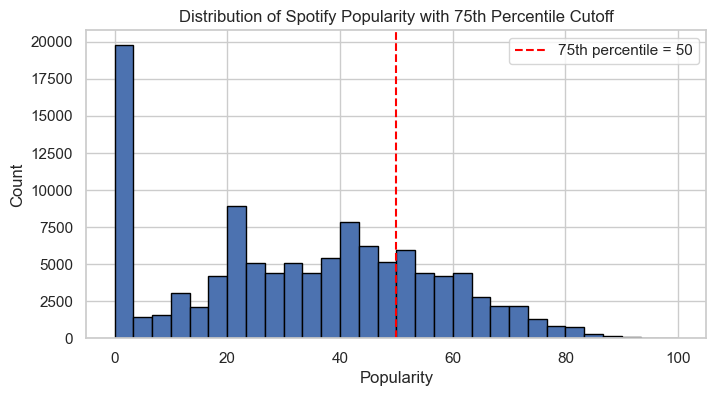

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_tracks["popularity"], bins=30, edgecolor="black")
plt.axvline(pop_cutoff, color="red", linestyle="--", label=f"75th percentile = {pop_cutoff:.0f}")
plt.title("Distribution of Spotify Popularity with 75th Percentile Cutoff")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.legend()
plt.show()


## EDA Section
In this section we will explore the data set more through different plots to understand trends and interpret why the model may behave a certain way.


### Distribution of Popular vs Non-Popular Songs

Before modeling, it is useful to check how many songs are labeled as popular (is_popular = 1) versus not popular (is_popular = 0).
This tells us whether the classes are balanced or imbalanced, and helps interpret model performance later (e.g., why the model may favor one class).


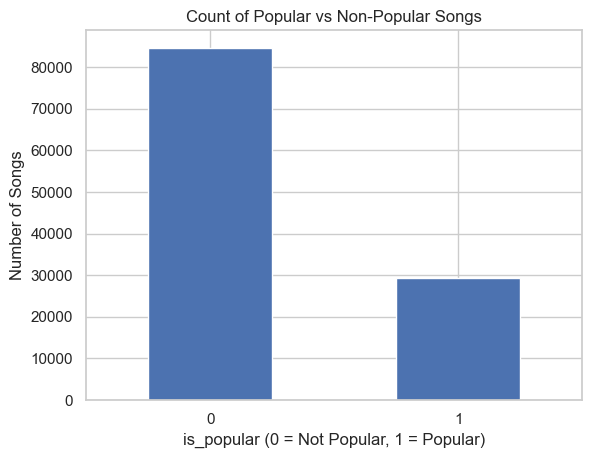

is_popular
0    0.742392
1    0.257608
Name: proportion, dtype: float64

In [7]:
df_tracks["is_popular"].value_counts().plot(
    kind="bar",
    rot=0
)
plt.title("Count of Popular vs Non-Popular Songs")
plt.xlabel("is_popular (0 = Not Popular, 1 = Popular)")
plt.ylabel("Number of Songs")
plt.show()

df_tracks["is_popular"].value_counts(normalize=True)

#### What does this mean?
 - Around 74% of the songs in the dataset are not popular
 - Only 26% of the songs are classified as popular

This indicates a class imbalance, where the negative class is much larger than the positive class. This imbalance is important because it influences model behavior. Logistic Regression becomes more confident in predicting the majority class, which explains the higher recall for non-popular songs and lower recall for popular ones. Only a minority of tracks reach the popularity threshold, which aligns with real-world streaming patterns and supports the motivation for this project.

### Distributions of Audio Features

Histograms show how each numeric audio feature is distributed (e.g., skewed, uniform, or normal).
Understanding the ranges and shapes of features like danceability, energy, valence, and tempo helps interpret what “typical” songs look like in the dataset and whether any transformations might be needed.

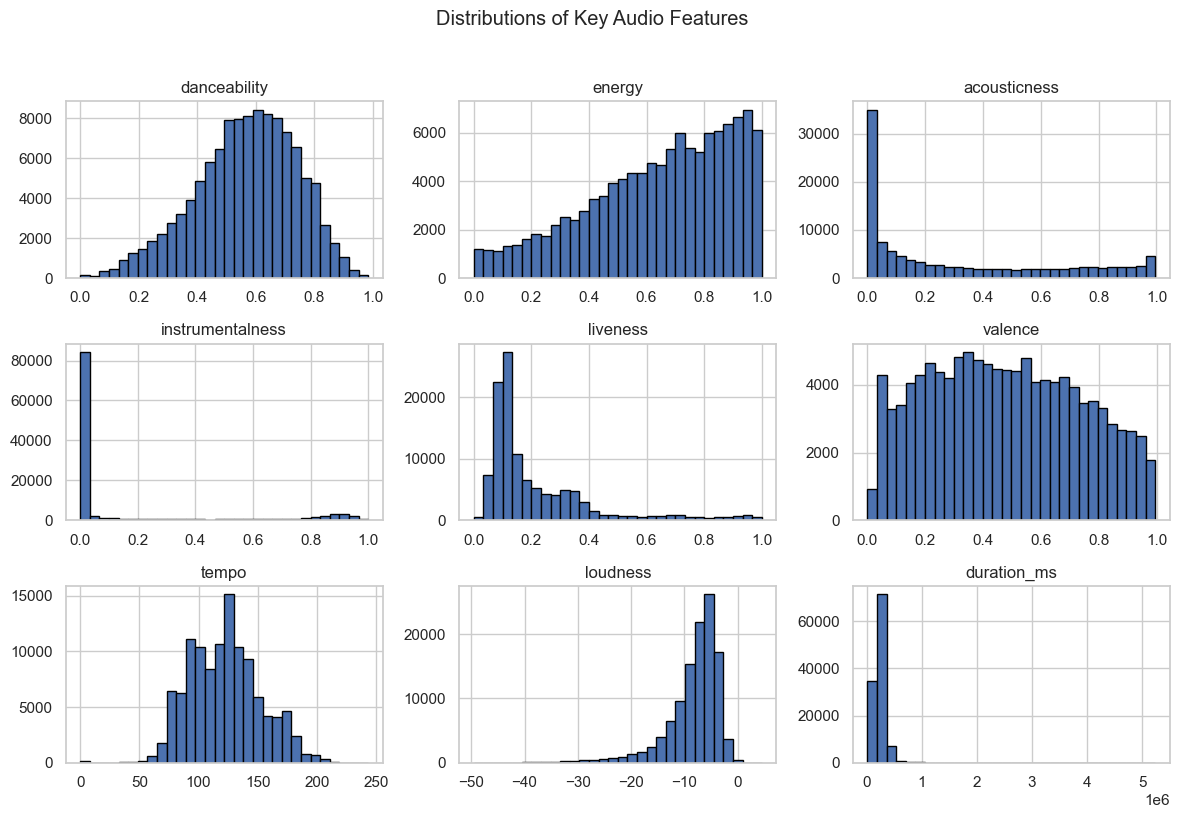

In [8]:
numeric_features = [
    "danceability",
    "energy",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "loudness",
    "duration_ms"
]

df_tracks[numeric_features].hist(
    bins=30,
    figsize=(12, 8),
    edgecolor="black"
)
plt.suptitle("Distributions of Key Audio Features", y=1.02)
plt.tight_layout()
plt.show()


#### What does this mean?

The histograms show that Spotify audio features are mostly NOT uniformly distributed. Features such as acousticness, instrumentalness, and liveness are heavily right-skewed, indicating that most tracks are studio-recorded, vocal, and non-acoustic. Tempo and danceability follow more normal distributions centered around typical mainstream song characteristics. Loudness is tightly clustered near −10 dB, consistent with modern production standards.

These patterns confirm that the dataset is clean and realistic. They also reveal natural variation in features such as valence, energy, and danceability, which are likely to contribute to predicting a song’s popularity. This EDA step provides insight into how audio features behave across the dataset and helps contextualize later modeling results.

### Correlation Between Audio Features and Popularity

A correlation heatmap summarizes pairwise linear relationships between numeric features and the popularity score.
This helps identify which audio attributes are most associated with higher popularity and whether any features are highly correlated with each other (potential redundancy).

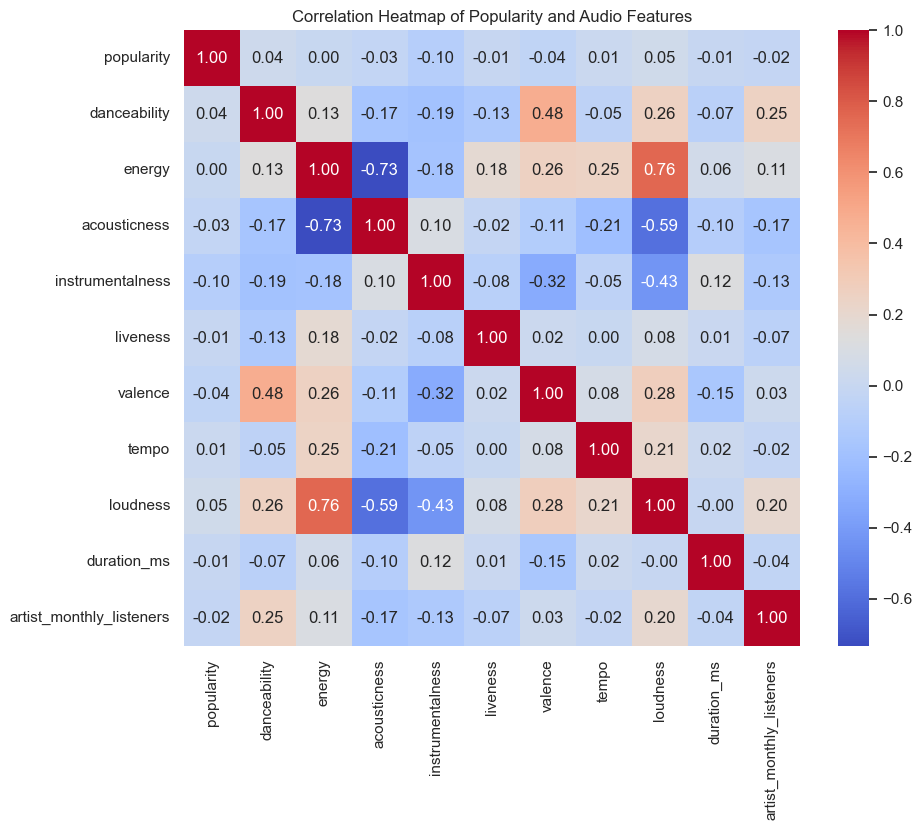

In [9]:
corr_cols = [
    "popularity",
    "danceability",
    "energy",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "loudness",
    "duration_ms",
    "artist_monthly_listeners"
]

plt.figure(figsize=(10, 8))
corr = df_tracks[corr_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Popularity and Audio Features")
plt.show()


#### What does this mean?

The correlation heatmap shows that no single audio attribute has a strong linear relationship with popularity.
Popularity appears to be influenced by a combination of factors rather than any one feature alone, which justifies the use of a classification model rather than a simple regression approach.

Strong correlations exist between audio features (e.g., loudness–energy, acousticness–energy), reflecting natural musical properties.

Artist monthly listeners shows only a small positive correlation with popularity, suggesting that artist fame matters but not in a purely linear way. This supports the inclusion of categorical “mainstream level” instead.

Overall, this heatmap highlights the complexity of predicting popularity and reinforces the need for multivariate machine learning models.

### Comparing Audio Features Between Popular and Non-Popular Songs

Boxplots allow us to compare the distributions of each feature for popular (is_popular = 1) and non-popular (is_popular = 0) songs.
If the boxes look noticeably different, it suggests that feature may be informative for predicting popularity.

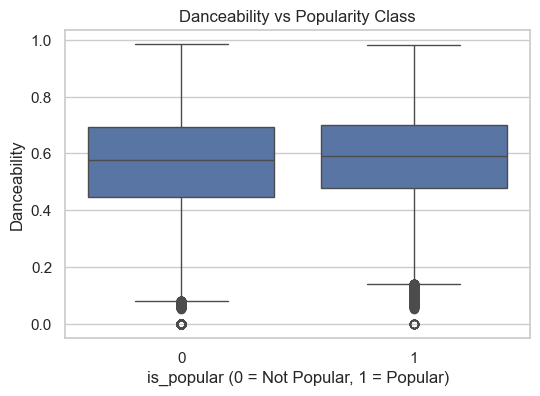

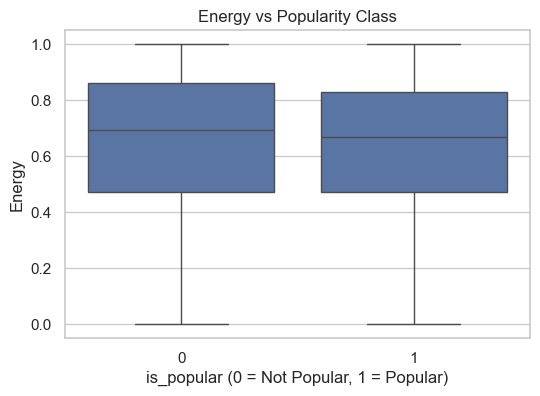

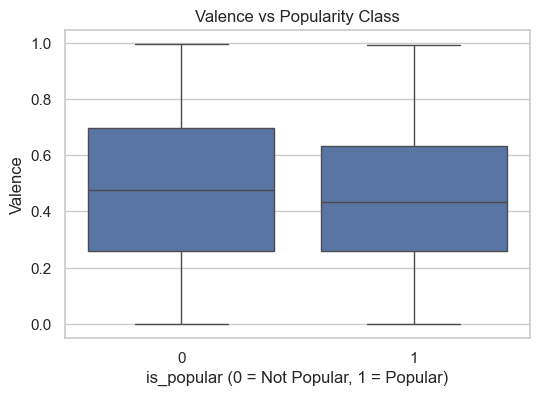

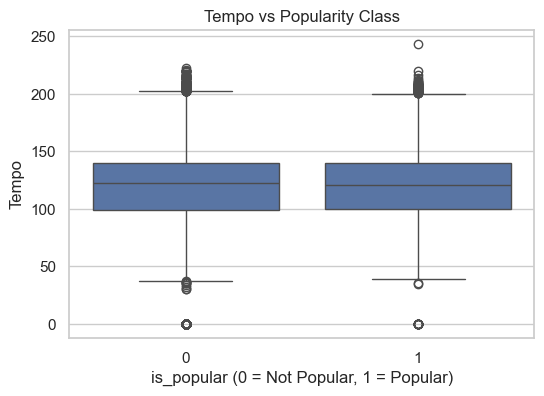

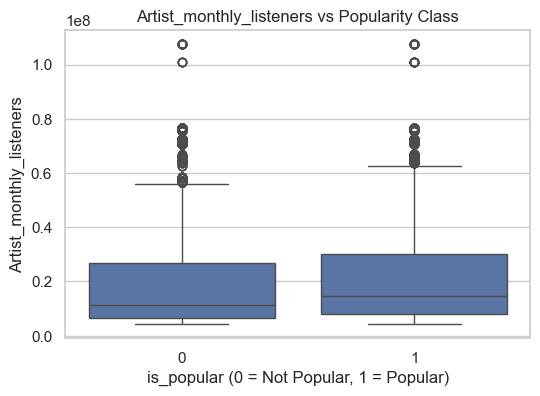

In [10]:
for col in ["danceability", "energy", "valence", "tempo", "artist_monthly_listeners"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_tracks, x="is_popular", y=col)
    plt.title(f"{col.capitalize()} vs Popularity Class")
    plt.xlabel("is_popular (0 = Not Popular, 1 = Popular)")
    plt.ylabel(col.capitalize())
    plt.show()


#### What does this mean?

The boxplots show that popular and non-popular songs share very similar distributions for most audio features. While small differences exist (e.g., slightly higher danceability for popular tracks), these differences are minor and show heavy distribution overlap.

In contrast, artist monthly listeners show the clearest separation between classes, with popular songs associated with significantly larger listener bases. This indicates that artist popularity plays a larger role in determining song popularity than audio features alone.

These findings support the hypothesis that “musically good” songs do not guarantee high popularity — external factors such as artist fame have a much stronger influence.

### Popularity Rate by Artist Mainstream Level

Here we examine how the probability of a song being popular changes with the artist's mainstream level (0 = less popular artists, 1 = mid-level, 2 = mainstream).
This directly tests the hypothesis that artist fame influences song popularity, beyond the audio features alone.

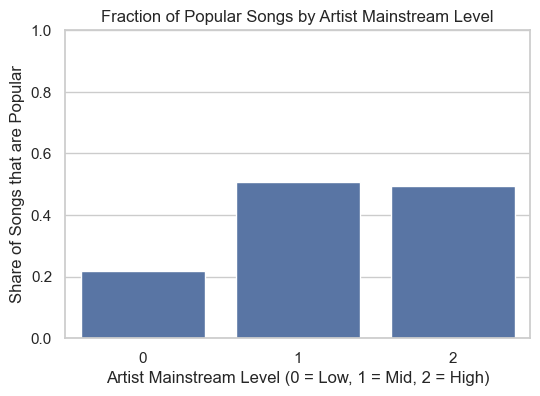

,artist_mainstream_level,is_popular
0,0,0.217704
1,1,0.507305
2,2,0.493822


In [11]:
mainstream_popularity = (
    df_tracks.groupby("artist_mainstream_level")["is_popular"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=mainstream_popularity,
    x="artist_mainstream_level",
    y="is_popular"
)
plt.title("Fraction of Popular Songs by Artist Mainstream Level")
plt.xlabel("Artist Mainstream Level (0 = Low, 1 = Mid, 2 = High)")
plt.ylabel("Share of Songs that are Popular")
plt.ylim(0, 1)
plt.show()

mainstream_popularity


#### What does this mean?

Artist mainstream level is one of the strongest predictors of song popularity.
Songs from low-fame artists have only a ~22% chance of reaching the popularity threshold, while songs from mid-tier and high-tier artists are more than twice as likely to become popular (~50%).

This supports the claim that popularity is heavily influenced by factors outside a song’s musical attributes. It also explains why our model performs better when artist-related metadata is included.

### Popularity by Track Genre

Different genres may have different baseline popularity levels (e.g., pop vs classical).
By computing the fraction of popular songs within each genre, we can see which genres tend to produce more popular tracks and whether genre is an important predictive signal.

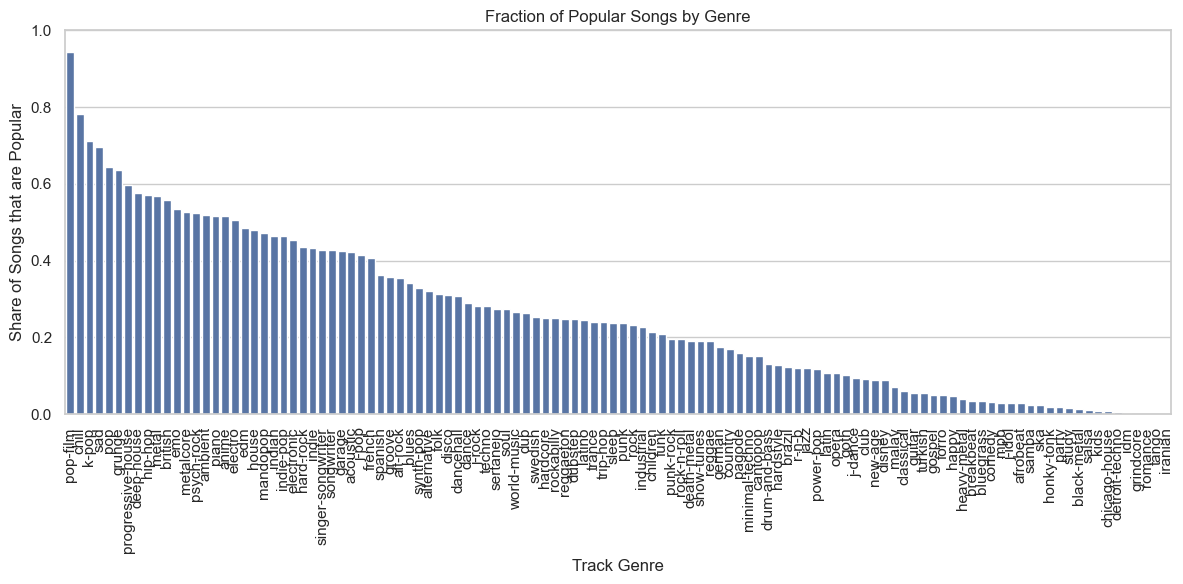

,track_genre,is_popular
0,pop-film,0.944000
1,chill,0.783000
2,k-pop,0.712713
3,sad,0.696000
4,pop,0.644000
5,grunge,0.637000
6,progressive-house,0.598000
7,deep-house,0.575000
8,hip-hop,0.572000
9,metal,0.569000


In [12]:
genre_popularity = (
    df_tracks.groupby("track_genre")["is_popular"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_popularity,
    x="track_genre",
    y="is_popular"
)
plt.title("Fraction of Popular Songs by Genre")
plt.xlabel("Track Genre")
plt.ylabel("Share of Songs that are Popular")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

genre_popularity.head(10)



#### What does this mean?

The distribution of popular songs varies dramatically by genre. Genres such as pop, chill, K-pop, and film soundtracks have the highest concentration of popular tracks (60–90%), while niche genres like classical, jazz, metal, and experimental categories show very low popularity rates (below 20%).

This indicates that genre is a strong predictor of popularity and suggests that popularity is influenced not only by song-level audio features but also by broader cultural and market-driven factors such as playlist exposure and audience size. These findings reinforce the importance of including categorical variables like genre in the predictive model.

### Relationship Between Artist Monthly Listeners and Song Popularity

A scatterplot (with some jitter or sampling) can show whether songs from artists with more monthly listeners are more likely to be popular.
Because listeners are highly skewed, we use a log scale on the x-axis.

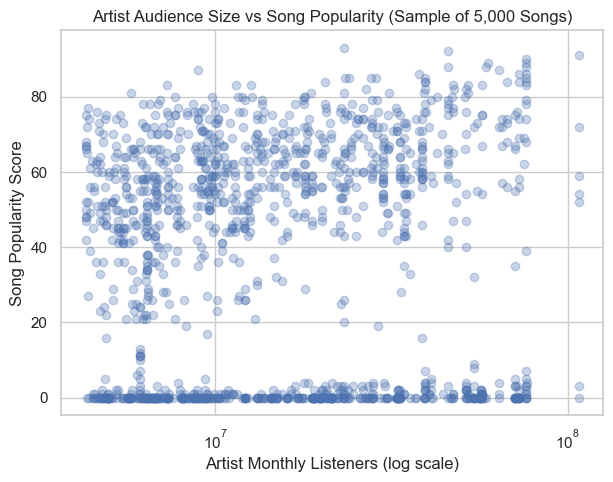

In [13]:
# Take a random sample for clearer plotting
sample_df = df_tracks.sample(n=5000, random_state=42)

plt.figure(figsize=(7,5))
plt.scatter(
    sample_df["artist_monthly_listeners"],
    sample_df["popularity"],
    alpha=0.3
)
plt.xscale("log")
plt.xlabel("Artist Monthly Listeners (log scale)")
plt.ylabel("Song Popularity Score")
plt.title("Artist Audience Size vs Song Popularity (Sample of 5,000 Songs)")
plt.show()


#### What does this mean?

The scatterplot shows a clear nonlinear relationship between artist audience size and song popularity. Songs from lesser-known artists almost never reach high popularity scores, while songs from mid-tier and high-tier artists display a much wider range and higher ceiling in popularity.

Although the relationship is noisy (even major artists release low-performing tracks) the overall upward trend confirms that artist reach plays a significant role in determining a song’s success. This visualization strengthens the case for incorporating artist metadata, such as monthly listeners and mainstream level, into the predictive model.

Clean up dataset before saving the cleansed one. Drop any more rows and reorder the columns

In [14]:
new_order = [
    'main_artist',
    'artist_mainstream_level',
    'track_name',
    'is_popular',
    'popularity',
    'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'track_genre',
    'artist_monthly_listeners'
]

# Drop the original artists column
df_tracks = df_tracks.drop(columns=["artists"])

# Reorder
df_tracks = df_tracks[new_order].copy()

# Check result
df_tracks.head()


,main_artist,artist_mainstream_level,track_name,is_popular,popularity,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_monthly_listeners
0,Gen Hoshino,0,Comedy,1,73,230666,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,NaN
1,Ben Woodward,0,Ghost - Acoustic,1,55,149610,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,NaN
2,ZAYN,1,To Begin Again,1,57,210826,False,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,24323031.0
3,Kina Grannis,0,Can't Help Falling In Love,1,71,201933,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,NaN
4,Chord Overstreet,0,Hold On,1,82,198853,False,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,5202733.0


Save the cleansed dataset

In [15]:
df_tracks.to_csv("../data/spotify_cleaned.csv", index=False)